In [3]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
import os
import glob
import pickle
from time import time
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
 
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
from ptsa.data.filters import MorletWaveletFilter
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
from eeg_plotting import plot_trace

In [4]:
def epoch_fr_power(subj_sess,
                   lfp_proc, 
                   fr_df,
                   chan_to_clus,
                   chans=None,
                   log_power=False,
                   z_power='',
                   freq_params={'low': 2, 'high': 150, 'num': 50}, 
                   epoch_size=1000, 
                   epoch_cut=3,
                   input_dir='/data3/scratch/dscho/frLfp/data/lfp/morlet',
                   output_dir='/data3/scratch/dscho/frLfp/data/epoch',
                   power_file_suffix='_width5',
                   load_existing=True,
                   save_files=False,
                   verbose=True,):
    """Divide each channel into epochs, and calculate the mean firing rate and
    power (at each frequency) within each epoch.
    
    Also calculate narrowband and broadband power for each epoch, using a
    robust regression model for the latter.
    
    Parameters
    ----------
    subj_sess : str
        e.g. 'U367_env2'
    lfp_proc : ptsa.data.timeseries.TimeSeries
        An n_channels x n_timepoints TimeSeries of the processed LFP data.
    fr_df : pandas.core.frame.DataFrame
        A DataFrame version of session_spikes, of sorts. n_clusters long and
        stores spikes, fr, and interp_mask for each cluster across all channels 
        in the session, along with some metadata.
    chan_to_clus : collections.OrderedDict
        Mapping between each unique channel in the recording session and a list
        of corresponding (across channel) cluster numbers (only has keys for
        channels with spikes!).
    chans : list or numpy.ndarray
        A list of channel names to process. Default is to use 
        all channels in lfp_proc.
    log_power : bool
        If True, power values are log10 transformed after epoching.
    z_power : str
        'withinfreq' -- Power values are Z-scored across epochs, 
            separately for each frequency.
        'acrossfreq' -- Power values are Z-scored across epochs 
            and frequencies. 
        Transform is applied after epoching. If log_power is True, 
        log transform is done before Z-scoring.
    freq_params : dict
        Keys must be 'low', 'high', and 'num'. Gives the frequency
        range and number of frequencies used in calculating power
        from LFP data through Morlet decomposition.
    epoch_size : int
        The number of timepoints that will comprise each epoch.
    epoch_cut : int
        The number of epochs to cut from the beginning and end
        of the recording session (to remove edge effects).
    input_dir : str
        Directory where input data are loaded.
    output_dir : str
        Directory where output files are loaded/saved.
    power_file_suffix : str
        The suffix to use in selecting power files to load from
        input_dir.
    load_existing : bool
        If True and output files exist, load and return them
        rather than reprocessing epochs.
    save_files : bool
        If True, output TimeSeries objects are saved as hdf5 files.
        If files already exist, load_existing is False, and save_files
        is True, then existing files are overwritten!
    verbose : bool
        If True, print statements report what the function is doing
        in several places.
        
    Returns
    -------
    epoch_fr : ptsa.data.timeseries.TimeSeries
        Mean firing rate for each epoch, for each cluster in the
        session. Dims are cluster x epoch.
    epoch_power : ptsa.data.timeseries.TimeSeries
        Mean power for each frequency, for each epoch, for each
        channel in the session. Dims are channel x epoch x freq.
    epoch_band_power : ptsa.data.timeseries.TimeSeries
        Mean power for frequencies within delta, theta, alpha, beta,
        and gamma bands; along with the slope and intercept of a robust
        robust regression model predicting power at each frequency for
        a given channel/epoch. Broadband power is also reported as the
        mean predicted value from the regression fit. Dims are 
        channel x epoch x freq.
    """
    # Load epoched data if it exists.
    # -----------------------------------
    epoch_fr_file = os.path.join(output_dir, '{}_epoch_fr.hdf'.format(subj_sess))
    epoch_power_file = os.path.join(output_dir, '{}_epoch_power{}.hdf'.format(subj_sess, power_file_suffix))
    epoch_band_power_file = os.path.join(output_dir, '{}_epoch_band_power{}.hdf'.format(subj_sess, power_file_suffix))
    files_exist = (os.path.exists(epoch_fr_file) 
                   and os.path.exists(epoch_power_file) 
                   and os.path.exists(epoch_band_power_file))
    if files_exist and load_existing:
        if verbose:
            print('Loading epoched spike and power data.')
        epoch_fr = TimeSeries.from_hdf(epoch_fr_file)
        epoch_power = TimeSeries.from_hdf(epoch_power_file)
        epoch_band_power = TimeSeries.from_hdf(epoch_band_power_file)
        return epoch_fr, epoch_power, epoch_band_power
    
    # Process data into epochs.
    # -------------------------
    start_time = time()
    if verbose:
        print('Processing spike and power data into epochs.')
    
    # Get channels and corresponding clusters to process.
    if chans is None:
        chans = lfp_proc.channel.data
    clusters = []
    for chan in chans:
        clusters += chan_to_clus[chan]
    
    # Get time bins to divide the data into 500ms epochs, cutting
    # out the first and last (+remainder) 3000 timepoints (1500ms).
    n_timepoints = lfp_proc.shape[1]    
    time_bins = manning_utils.get_epochs(np.arange(n_timepoints), 
                                         epoch_size=epoch_size, 
                                         cut=epoch_cut)

    # Get wavelet frequencies and assign them to bands of interest.
    freqs, freq_bands = manning_utils.get_freqs(low=freq_params['low'], 
                                                high=freq_params['high'], 
                                                num=freq_params['num'])
    # X is the independent variable for the robust regression.
    X = sm.add_constant(np.log10(freqs))
    
    # Tag for explaining processing steps (done in order L->R).
    process_tag = 'power' + power_file_suffix + '_epoch'
    if log_power:
        process_tag += '_log'
    if z_power:
        process_tag += '_Z{}'.format(z_power)
    
    # Get the mean firing rate for each epoch, for each cluster.
    # ----------------------------------------------------------
    epoch_fr = []
    for clus in clusters:
        # Get the mean firing rate (in Hz) for each epoch.
        clus_fr = fr_df.loc[fr_df.clus==clus, 'fr'].iat[0]
        epoch_fr_row = []
        for epoch_start, epoch_stop in time_bins:
            epoch_fr_row.append(2 * np.sum(clus_fr[epoch_start:epoch_stop]))
        epoch_fr.append(epoch_fr_row)

    epoch_fr = TimeSeries(np.array(epoch_fr), name=lfp_proc.name,
                          dims=['cluster', 'epoch'],
                          coords={'cluster': clusters,
                                  'epoch': np.arange(len(time_bins)),
                                  'samplerate': lfp_proc.samplerate.data / epoch_size},
                          attrs={'epoch_bins': np.array(time_bins)})
    
    # Get narrowband and broadband power for each epoch, for each channel.
    # --------------------------------------------------------------------
    epoch_power = []
    epoch_band_power = []
    for i, chan in enumerate(chans):
        if i % 8 == 0 and verbose:
            print('Loading power data for {} channel {}.'.format(subj_sess, chan))
        f = os.path.join(input_dir, '{}_ch{}_power{}.hdf'.format(subj_sess, chan, power_file_suffix))
        power = TimeSeries.from_hdf(f).data.squeeze() # frequency x time
        epoch_power_row = []
        epoch_band_power_row = []
        # For timepoints in each epoch, get the mean power over time, 
        # at each frequency.
        for epoch_start, epoch_stop in time_bins:
            epoch_power_row.append(np.mean(power[:, epoch_start:epoch_stop], axis=1))
        
        epoch_power_row = np.array(epoch_power_row) # n_epochs x n_freqs
        
        # Transform epoched power values.
        if log_power:
            epoch_power_row = np.log10(epoch_power_row)
            if verbose and i == 0:
                print('Log transforming epoched power values.')
        if z_power == 'withinfreq':
            epoch_power_row = (epoch_power_row - np.mean(epoch_power_row, axis=0)) / np.std(epoch_power_row, axis=0)
            if verbose and i == 0:
                print('Z-scoring epoched power values within each frequency.')
        elif z_power == 'acrossfreq':
            epoch_power_row = (epoch_power_row - np.mean(epoch_power_row)) / np.std(epoch_power_row)
            if verbose and i == 0:
                print('Z-scoring epoched power values across frequencies.')
            
        for epoch in range(epoch_power_row.shape[0]):
            # Get mean delta, theta, alpha, beta, and gamma power.   
            delta_power = np.mean(epoch_power_row[epoch, (freqs<4)])
            theta_power = np.mean(epoch_power_row[epoch, (freqs>=4) & (freqs<8)])
            alpha_power = np.mean(epoch_power_row[epoch, (freqs>=8) & (freqs<12)])
            beta_power = np.mean(epoch_power_row[epoch, (freqs>=12) & (freqs<30)])
            gamma_power = np.mean(epoch_power_row[epoch, (freqs>=30)])

            # Fit a robust linear regression to estimate the intercept 
            # and slope (broadband tilt) of the power spectrum. Broadband
            # power is the mean of the predicted values.
            y = epoch_power_row[epoch, :]
            huber_t = sm.RLM(y, X, M=sm.robust.norms.HuberT())
            hub_results = huber_t.fit()
            intercept, slope = hub_results.params
            epoch_band_power_row.append(
                    [delta_power, theta_power, alpha_power, beta_power, gamma_power, 
                     intercept, slope, np.mean(hub_results.predict())]
                )

        epoch_power.append(epoch_power_row) # n_channels x n_epochs x n_freqs
        epoch_band_power.append(epoch_band_power_row) # n_channels x n_epochs x (n_freq_bands + 3)

    epoch_power = TimeSeries(np.array(epoch_power), name=lfp_proc.name, 
                             dims=['channel', 'epoch', 'freq'],
                             coords={'channel': chans,
                                     'epoch': np.arange(len(time_bins)),        
                                     'freq': freqs,
                                     'samplerate': lfp_proc.samplerate.data / epoch_size},
                             attrs={'epoch_bins': np.array(time_bins),
                                    'process_tag': process_tag})
    
    epoch_band_power = TimeSeries(np.array(epoch_band_power), name=lfp_proc.name, 
                                  dims=['channel', 'epoch', 'freq'],
                                  coords={'channel': chans,
                                          'epoch': np.arange(len(time_bins)),        
                                          'freq': (list(freq_bands.keys()) 
                                                   + ['intercept', 'bband_tilt', 'bband_power']),
                                          'samplerate': lfp_proc.samplerate.data / epoch_size},
                                  attrs={'epoch_bins': np.array(time_bins),
                                         'process_tag': process_tag})
    
    if save_files:
        epoch_fr.to_hdf(epoch_fr_file)
        epoch_power.to_hdf(epoch_power_file)
        epoch_band_power.to_hdf(epoch_band_power_file)
        if verbose:
            print('Saved epoched data to files:\n\t{}\n\t{}\n\t{}.'
                  .format(epoch_fr, epoch_power, epoch_band_power))

    duration = time() - start_time
    if verbose:
        print('Done in {} secs.'.format(int(duration)))
        
    return epoch_fr, epoch_power, epoch_band_power

In [149]:
#reload(manning_utils)
reload(manning_analysis)

<module 'manning_analysis' from '/home1/dscho/code/projects/manning_replication/manning_analysis.py'>

In [5]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
data_dir = dirs['data']
figure_dir = dirs['figs']

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.



In [6]:
## Preprocess a recording session, and save the raw LFP, processed LFP,
# spike data, and subjects' DataFrame.
subj_sess = 'U367_env2'
subj, sess = subj_sess.split('_')
subj_df, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
        subj_sess, subj_df, subj_df_file, overwrite=False
    )

In [7]:
# Z-score firing rates for units 1 and 2 of channel 1.
unit1 = session_spikes['1']['fr'][0, :]
unit2 = session_spikes['1']['fr'][1, :]
zunit1 = (unit1 - np.mean(unit1)) / np.std(unit1)
zunit2 = (unit2 - np.mean(unit2)) / np.std(unit2)

In [6]:
# Get power and phase without parallelizing.
freqs = np.logspace(np.log10(2), np.log10(200), 50, base=10)
power, phase = manning_analysis.run_morlet(lfp_proc.sel(channel=['1']), width=5, freqs=freqs, log_power=False, z_power=False, overwrite=False)
# logpower, _ = manning_analysis.run_morlet(lfp_proc.sel(channel=['1']), width=5, freqs=freqs, log_power=True, z_power=False, overwrite=False)
# zpower, _ = manning_analysis.run_morlet(lfp_proc.sel(channel=['1']), width=5, freqs=freqs, log_power=False, z_power=True, overwrite=False)
# zlogpower, phase = manning_analysis.run_morlet(lfp_proc.sel(channel=['1']), width=5, freqs=freqs, log_power=True, z_power=True, overwrite=False)

# power = power.squeeze()
# logpower = logpower.squeeze()
# zpower = zpower.squeeze()
# zlogpower = zlogpower.squeeze()
# phase = phase.squeeze()

Calculating power and phase.
CPP total time wavelet loop:  36.35930681228638
Saving power and phase:
	/data3/scratch/dscho/frLfp/data/lfp/morlet/U367_env2_ch1_power_width5_2-200Hz-50log10steps.hdf
	/data3/scratch/dscho/frLfp/data/lfp/morlet/U367_env2_ch1_phase_width5_2-200Hz-50log10steps.hdf


In [8]:
# Load Matlab-calculated power values and recalculate transformed values.
mat = sio.loadmat('/data3/scratch/dscho/frLfp/analyses/1-multiUnit0-remSpikes1(-2:8)-6Bands-2-200/rateAndPow/U367-env2-1.mat')
# matpow = TimeSeries(mat['eegPowAll'], 
#                     dims=['frequency', 'time'], 
#                     name=zpower.name, 
#                     coords=zpower.coords)
# logmatpow = np.log10(matpow)
# zmatpow = (matpow - matpow.mean(dim='time')) / matpow.std(dim='time')
# zlogmatpow = (logmatpow - logmatpow.mean(dim='time')) / logmatpow.std(dim='time')
#mat_power_z.to_hdf('/data3/scratch/dscho/frLfp/data/lfp/morlet/U367_env2_ch1_power_matlab_width5_log_Z.hdf')

Text(0.5,1.1,'Log-transformed and Z-log-transformed power values')

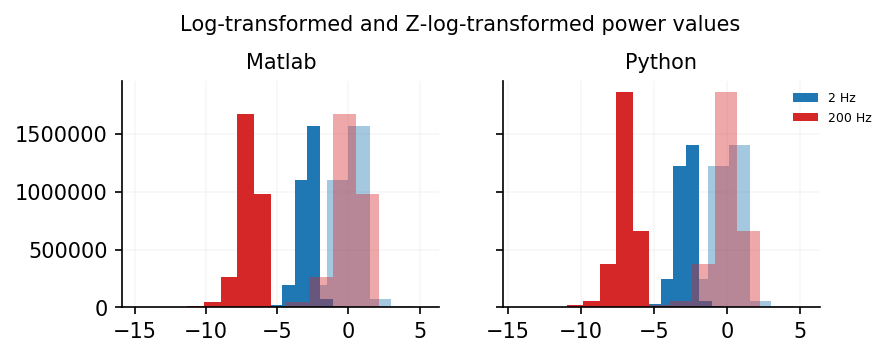

In [131]:
# Plot distrubtions for log-transformed power at 2Hz and 200Hz,
# before and after Z-scoring.

fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharey=True)

ax[0].hist(logmatpow[0, :])
ax[0].hist(logmatpow[49, :])
ax[0].hist(zlogmatpow[0, :], alpha=0.4, color='C0')
ax[0].hist(zlogmatpow[49, :], alpha=0.4, color='C1')
ax[0].set_title('Matlab')

ax[1].hist(logpower[0, :], label='2 Hz')
ax[1].hist(logpower[49, :], label='200 Hz')
ax[1].hist(zlogpower[0, :], alpha=0.4, color='C0', label='')
ax[1].hist(zlogpower[49, :], alpha=0.4, color='C1', label='')
ax[1].set_title('Python')
ax[1].legend(bbox_to_anchor=(1.2, 1), prop={'size': 6})

fig.suptitle('Log-transformed and Z-log-transformed power values', y=1.1)

Text(0.5,1,'Z-scored firing rates')

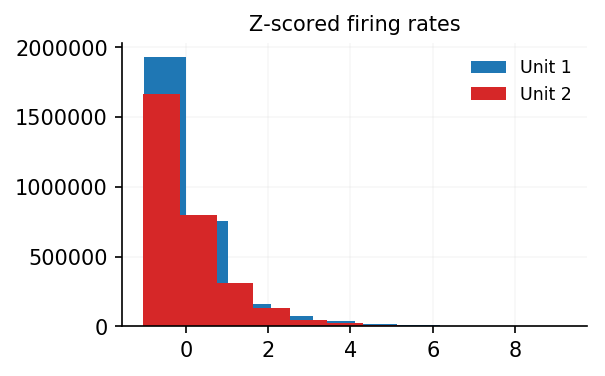

In [127]:
# Plot Z-scored firing rate distributions for units 1 and 2.
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
ax.hist(zunit1, label='Unit 1')
ax.hist(zunit2, label='Unit 2')
ax.legend()
ax.set_title('Z-scored firing rates')

In [149]:
for i in range(50):
    print('{:.02f} {:.02f} {:.02f} {:.02f} {:.02f}'
          .format(freqs[i], 
                  stats.pearsonr(power[i, :], matpow[i, :])[0],
                  stats.pearsonr(logpower[i, :], logmatpow[i, :])[0],
                  stats.pearsonr(zpower[i, :], zmatpow[i, :])[0],
                  stats.pearsonr(zlogpower[i, :], zlogmatpow[i, :])[0]))

2.00 1.00 1.00 1.00 1.00
2.20 1.00 1.00 1.00 1.00
2.41 1.00 1.00 1.00 1.00
2.65 1.00 1.00 1.00 1.00
2.91 1.00 1.00 1.00 1.00
3.20 1.00 1.00 1.00 1.00
3.52 1.00 1.00 1.00 1.00
3.86 1.00 1.00 1.00 1.00
4.24 1.00 1.00 1.00 1.00
4.66 1.00 1.00 1.00 1.00
5.12 1.00 1.00 1.00 1.00
5.62 1.00 0.99 1.00 0.99
6.18 1.00 0.99 1.00 0.99
6.79 1.00 0.99 1.00 0.99
7.46 1.00 0.99 1.00 0.99
8.19 1.00 0.99 1.00 0.99
9.00 1.00 0.99 1.00 0.99
9.88 1.00 0.98 1.00 0.98
10.86 1.00 0.98 1.00 0.98
11.93 1.00 0.97 1.00 0.97
13.10 1.00 0.97 1.00 0.97
14.39 1.00 0.97 1.00 0.97
15.81 1.00 0.96 1.00 0.96
17.37 1.00 0.96 1.00 0.96
19.08 1.00 0.95 1.00 0.95
20.96 1.00 0.95 1.00 0.95
23.03 1.00 0.94 1.00 0.94
25.30 1.00 0.94 1.00 0.94
27.79 1.00 0.94 1.00 0.94
30.53 1.00 0.93 1.00 0.93
33.54 1.00 0.93 1.00 0.93
36.84 1.00 0.93 1.00 0.93
40.47 1.00 0.92 1.00 0.92
44.46 1.00 0.91 1.00 0.91
48.84 1.00 0.88 1.00 0.88
53.65 0.99 0.86 0.99 0.86
58.94 0.99 0.84 0.99 0.84
64.75 0.99 0.84 0.99 0.84
71.13 0.99 0.85 0.99 0.85
78.1

## Epoching

In [9]:
epoch_fr, epoch_power_zw, epoch_band_power_zw = manning_analysis.epoch_fr_power(subj_sess, lfp_proc, fr_df, chan_to_clus, 
                                                                          chans=['1'],
                                                                          log_power=False,
                                                                          z_power='withinfreq',
                                                                          freq_params={'low': 2, 'high': 200, 'num': 50},
                                                                          power_file_suffix='_width5_2-200Hz-50log10steps',
                                                                          load_existing=False, 
                                                                          save_files=False)

_, epoch_power_za, epoch_band_power_za = manning_analysis.epoch_fr_power(subj_sess, lfp_proc, fr_df, chan_to_clus, 
                                                                          chans=['1'],
                                                                          log_power=False,
                                                                          z_power='acrossfreq',
                                                                          freq_params={'low': 2, 'high': 200, 'num': 50},
                                                                          power_file_suffix='_width5_2-200Hz-50log10steps',
                                                                          load_existing=False, 
                                                                          save_files=False)

_, epoch_power_lzw, epoch_band_power_lzw = manning_analysis.epoch_fr_power(subj_sess, lfp_proc, fr_df, chan_to_clus, 
                                                                          chans=['1'],
                                                                          log_power=True,
                                                                          z_power='withinfreq',
                                                                          freq_params={'low': 2, 'high': 200, 'num': 50},
                                                                          power_file_suffix='_width5_2-200Hz-50log10steps',
                                                                          load_existing=False, 
                                                                          save_files=False)

_, epoch_power_lza, epoch_band_power_lza = manning_analysis.epoch_fr_power(subj_sess, lfp_proc, fr_df, chan_to_clus, 
                                                                          chans=['1'],
                                                                          log_power=True,
                                                                          z_power='acrossfreq',
                                                                          freq_params={'low': 2, 'high': 200, 'num': 50},
                                                                          power_file_suffix='_width5_2-200Hz-50log10steps',
                                                                          load_existing=False, 
                                                                          save_files=False)

epoch_power_zw = epoch_power_zw.squeeze()
epoch_band_power_zw = epoch_band_power_zw.squeeze()
epoch_power_za = epoch_power_za.squeeze()
epoch_band_power_za = epoch_band_power_za.squeeze()
epoch_power_lzw = epoch_power_lzw.squeeze()
epoch_band_power_lzw = epoch_band_power_lzw.squeeze()
epoch_power_lza = epoch_power_lza.squeeze()
epoch_band_power_lza = epoch_band_power_lza.squeeze()

In [12]:
# Get the correlation matrix for power bands.
# Z-withinfreq
pd.DataFrame(np.corrcoef(epoch_band_power_zw.T), columns=epoch_band_power_zw.freq.data)

,delta,theta,alpha,beta,gamma,intercept,bband_tilt,bband_power
0,1.000000,0.860532,0.790603,0.747014,0.492978,0.892606,-0.448479,0.796113
1,0.860532,1.000000,0.851930,0.814167,0.561981,0.885700,-0.388177,0.850185
2,0.790603,0.851930,1.000000,0.815224,0.564694,0.832180,-0.332440,0.833021
3,0.747014,0.814167,0.815224,1.000000,0.756225,0.709553,-0.077952,0.928064
4,0.492978,0.561981,0.564694,0.756225,1.000000,0.254352,0.493679,0.885505
5,0.892606,0.885700,0.832180,0.709553,0.254352,1.000000,-0.712806,0.668945
6,-0.448479,-0.388177,-0.332440,-0.077952,0.493679,-0.712806,1.000000,0.044502
7,0.796113,0.850185,0.833021,0.928064,0.885505,0.668945,0.044502,1.000000


In [13]:
# Get the correlation matrix for power bands.
# Z-acrossfreq
pd.DataFrame(np.corrcoef(epoch_band_power_za.T), columns=epoch_band_power_za.freq.data)

,delta,theta,alpha,beta,gamma,intercept,bband_tilt,bband_power
0,1.000000,0.830819,0.768651,0.775609,0.498189,0.871211,-0.870733,0.872306
1,0.830819,1.000000,0.816884,0.796145,0.614271,0.965570,-0.964329,0.968855
2,0.768651,0.816884,1.000000,0.817066,0.653258,0.816294,-0.812690,0.826502
3,0.775609,0.796145,0.817066,1.000000,0.728673,0.791853,-0.788510,0.801312
4,0.498189,0.614271,0.653258,0.728673,1.000000,0.620886,-0.618018,0.629020
5,0.871211,0.965570,0.816294,0.791853,0.620886,1.000000,-0.999970,0.999749
6,-0.870733,-0.964329,-0.812690,-0.788510,-0.618018,-0.999970,1.000000,-0.999547
7,0.872306,0.968855,0.826502,0.801312,0.629020,0.999749,-0.999547,1.000000


In [31]:
# Get the correlation matrix for power bands.
# log Z-withinfreq
pd.DataFrame(np.corrcoef(epoch_band_power_lzw.T), columns=epoch_band_power_lzw.freq.data)

,delta,theta,alpha,beta,gamma,intercept,bband_tilt,bband_power
0,1.000000,0.366444,0.263735,0.258053,0.222187,0.681088,-0.393702,0.552097
1,0.366444,1.000000,0.616202,0.324975,0.038296,0.758049,-0.502481,0.507440
2,0.263735,0.616202,1.000000,0.491716,0.082786,0.643084,-0.367693,0.528019
3,0.258053,0.324975,0.491716,1.000000,0.441972,0.363658,0.052144,0.731597
4,0.222187,0.038296,0.082786,0.441972,1.000000,-0.221990,0.714155,0.795440
5,0.681088,0.758049,0.643084,0.363658,-0.221990,1.000000,-0.832604,0.386788
6,-0.393702,-0.502481,-0.367693,0.052144,0.714155,-0.832604,1.000000,0.188719
7,0.552097,0.507440,0.528019,0.731597,0.795440,0.386788,0.188719,1.000000


In [25]:
# Get the correlation matrix for power bands.
# log Z-acrossfreq
pd.DataFrame(np.corrcoef(epoch_band_power_lza.T), columns=epoch_band_power_lza.freq.data)

,delta,theta,alpha,beta,gamma,intercept,bband_tilt,bband_power
0,1.000000,0.359500,0.262185,0.255478,0.226056,0.810892,-0.750070,0.707425
1,0.359500,1.000000,0.631571,0.330109,0.043447,0.745819,-0.693908,0.643480
2,0.262185,0.631571,1.000000,0.498205,0.082521,0.638525,-0.551704,0.626360
3,0.255478,0.330109,0.498205,1.000000,0.439493,0.461757,-0.256514,0.706603
4,0.226056,0.043447,0.082521,0.439493,1.000000,0.067176,0.236083,0.589575
5,0.810892,0.745819,0.638525,0.461757,0.067176,1.000000,-0.949383,0.828979
6,-0.750070,-0.693908,-0.551704,-0.256514,0.236083,-0.949383,1.000000,-0.611338
7,0.707425,0.643480,0.626360,0.706603,0.589575,0.828979,-0.611338,1.000000


Text(0.5,0.98,'U367_env2 ch1 power band correlation matrices')

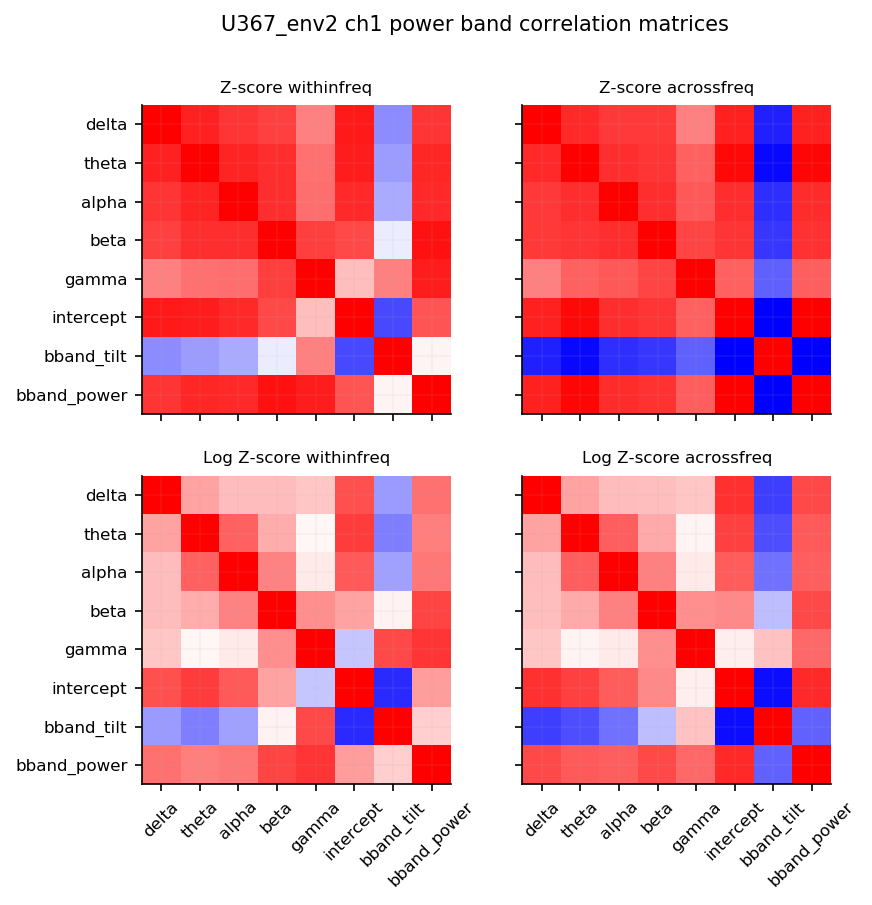

In [53]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=[6, 6], dpi=150)
ax = np.ravel(ax)

ax[0].imshow(pd.DataFrame(np.corrcoef(epoch_band_power_zw.T), columns=epoch_band_power_zw.freq.data),
             vmin=-1, vmax=1, cmap='bwr')
ax[0].set_xticks(range(len(epoch_band_power_zw.freq.data)))
ax[0].set_yticks(range(len(epoch_band_power_zw.freq.data)))
ax[0].set_yticklabels(epoch_band_power_zw.freq.data, fontsize=8)
ax[0].set_title('Z-score withinfreq', fontsize=8)


ax[1].imshow(pd.DataFrame(np.corrcoef(epoch_band_power_za.T), columns=epoch_band_power_za.freq.data),
             vmin=-1, vmax=1, cmap='bwr')
ax[1].set_title('Z-score acrossfreq', fontsize=8)

ax[2].imshow(pd.DataFrame(np.corrcoef(epoch_band_power_lzw.T), columns=epoch_band_power_lzw.freq.data),
             vmin=-1, vmax=1, cmap='bwr')
ax[2].set_xticks(range(len(epoch_band_power_zw.freq.data)))
ax[2].set_xticklabels(epoch_band_power_zw.freq.data, fontsize=8, rotation=45)
ax[2].set_yticks(range(len(epoch_band_power_zw.freq.data)))
ax[2].set_yticklabels(epoch_band_power_zw.freq.data, fontsize=8)
ax[2].set_title('Log Z-score withinfreq', fontsize=8)

ax[3].imshow(pd.DataFrame(np.corrcoef(epoch_band_power_lza.T), columns=epoch_band_power_lza.freq.data),
             vmin=-1, vmax=1, cmap='bwr')
ax[3].set_xticks(range(len(epoch_band_power_zw.freq.data)))
ax[3].set_xticklabels(epoch_band_power_zw.freq.data, fontsize=8, rotation=45)
ax[3].set_title('Log Z-score acrossfreq', fontsize=8)

fig.suptitle('{} ch1 power band correlation matrices'.format(subj_sess), fontsize=10)

In [62]:
# Get correlations between power band measures and unit firing.
# Z-withinfreq
for i in range(len(epoch_band_power_zw.freq)):
    print('{}: Unit 1 FR ({:.03f}), Unit 2 FR ({:.03f})'.format(
          epoch_band_power_zw.freq.data[i], 
          stats.pearsonr(epoch_fr[0, :], epoch_band_power_zw[:, i])[0], 
          stats.pearsonr(epoch_fr[1, :], epoch_band_power_zw[:, i])[0]))

delta: Unit 1 FR (0.030), Unit 2 FR (-0.008)
theta: Unit 1 FR (-0.022), Unit 2 FR (-0.020)
alpha: Unit 1 FR (0.001), Unit 2 FR (-0.025)
beta: Unit 1 FR (0.019), Unit 2 FR (-0.016)
gamma: Unit 1 FR (0.091), Unit 2 FR (0.023)
intercept: Unit 1 FR (-0.031), Unit 2 FR (-0.027)
bband_tilt: Unit 1 FR (0.088), Unit 2 FR (0.038)
bband_power: Unit 1 FR (0.049), Unit 2 FR (0.001)


In [60]:
# Get correlations between power band measures and unit firing.
# Z-acrossfreq
for i in range(len(epoch_band_power_za.freq)):
    print('{}: Unit 1 FR ({:.03f}), Unit 2 FR ({:.03f})'.format(
          epoch_band_power_za.freq.data[i], 
          stats.pearsonr(epoch_fr[0, :], epoch_band_power_za[:, i])[0], 
          stats.pearsonr(epoch_fr[1, :], epoch_band_power_za[:, i])[0]))

delta: Unit 1 FR (0.031), Unit 2 FR (-0.010)
theta: Unit 1 FR (-0.008), Unit 2 FR (-0.013)
alpha: Unit 1 FR (-0.000), Unit 2 FR (-0.025)
beta: Unit 1 FR (0.008), Unit 2 FR (-0.022)
gamma: Unit 1 FR (0.060), Unit 2 FR (0.013)
intercept: Unit 1 FR (0.017), Unit 2 FR (-0.003)
bband_tilt: Unit 1 FR (-0.017), Unit 2 FR (0.003)
bband_power: Unit 1 FR (0.016), Unit 2 FR (-0.004)


In [61]:
# Get correlations between power band measures and unit firing.
# log Z-withinfreq
for i in range(len(epoch_band_power_lzw.freq)):
    print('{}: Unit 1 FR ({:.03f}), Unit 2 FR ({:.03f})'.format(
          epoch_band_power_lzw.freq.data[i], 
          stats.pearsonr(epoch_fr[0, :], epoch_band_power_lzw[:, i])[0], 
          stats.pearsonr(epoch_fr[1, :], epoch_band_power_lzw[:, i])[0]))

delta: Unit 1 FR (0.028), Unit 2 FR (-0.004)
theta: Unit 1 FR (-0.180), Unit 2 FR (-0.082)
alpha: Unit 1 FR (-0.175), Unit 2 FR (-0.105)
beta: Unit 1 FR (0.084), Unit 2 FR (0.009)
gamma: Unit 1 FR (0.432), Unit 2 FR (0.180)
intercept: Unit 1 FR (-0.283), Unit 2 FR (-0.137)
bband_tilt: Unit 1 FR (0.438), Unit 2 FR (0.192)
bband_power: Unit 1 FR (0.227), Unit 2 FR (0.077)


In [63]:
# Get correlations between power band measures and unit firing.
# log Z-acrossfreq
for i in range(len(epoch_band_power_lza.freq)):
    print('{}: Unit 1 FR ({:.03f}), Unit 2 FR ({:.03f})'.format(
          epoch_band_power_lza.freq.data[i], 
          stats.pearsonr(epoch_fr[0, :], epoch_band_power_lza[:, i])[0], 
          stats.pearsonr(epoch_fr[1, :], epoch_band_power_lza[:, i])[0]))

delta: Unit 1 FR (0.028), Unit 2 FR (-0.004)
theta: Unit 1 FR (-0.181), Unit 2 FR (-0.083)
alpha: Unit 1 FR (-0.180), Unit 2 FR (-0.107)
beta: Unit 1 FR (0.071), Unit 2 FR (0.002)
gamma: Unit 1 FR (0.434), Unit 2 FR (0.185)
intercept: Unit 1 FR (-0.152), Unit 2 FR (-0.084)
bband_tilt: Unit 1 FR (0.271), Unit 2 FR (0.131)
bband_power: Unit 1 FR (0.101), Unit 2 FR (0.021)


In [158]:
# mat_epoch_fr, mat_epoch_power, mat_epoch_band_power = manning_analysis.epoch_fr_power(subj_sess, lfp_proc, fr_df, chan_to_clus, 
#                                                                                       chans=['1'], 
#                                                                                       power_file_suffix='_matlab_width5_log_Z',
#                                                                                       freq_params={'low': 2, 'high': 200, 'num': 50},
#                                                                                       load_existing=False, 
#                                                                                       save_files=False)

Processing spike and power data into epochs.
Loading power data for U367_env2 channel 1.
Done in 27 secs.


In [64]:
mat['smSpikeRate'][:, 3:-3].shape, epoch_fr.shape

((2, 2983), (2, 2983))

Text(0.5,1.04,'U367-env2 ch1')

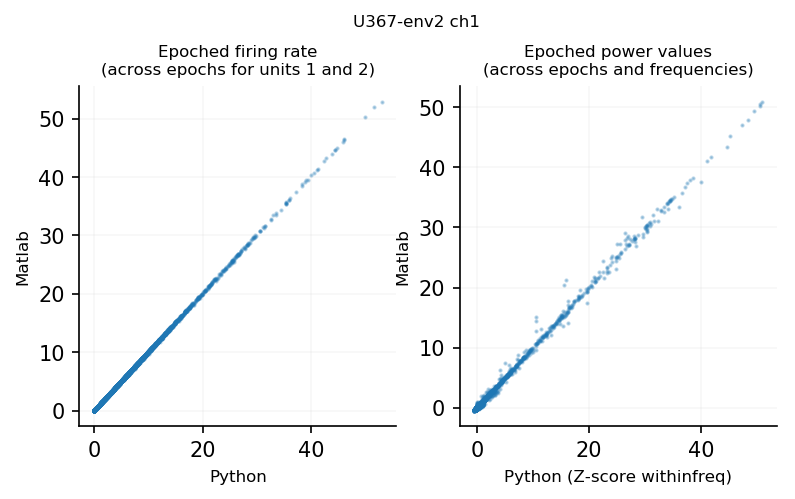

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].scatter(epoch_fr.data.flatten(), mat['smSpikeRate'][:, 3:-3].flatten(), s=1, alpha=0.3)
ax[0].set_xlabel('Python', fontsize=8)
ax[0].set_ylabel('Matlab', fontsize=8)
ax[0].set_title('Epoched firing rate\n(across epochs for units 1 and 2)', fontsize=8)

ax[1].scatter(epoch_power_zw.T.data.flatten(), mat['pow'][:, 3:-3].flatten(), s=1, alpha=0.3)
ax[1].set_xlabel('Python (Z-score withinfreq)', fontsize=8)
ax[1].set_ylabel('Matlab', fontsize=8)
ax[1].set_title('Epoched power values\n(across epochs and frequencies)', fontsize=8)

fig.suptitle('U367-env2 ch1', fontsize=8, y=1.04)

Text(0.5,1,'U367-env2 ch1: Epoched power values (across epochs and frequencies)')

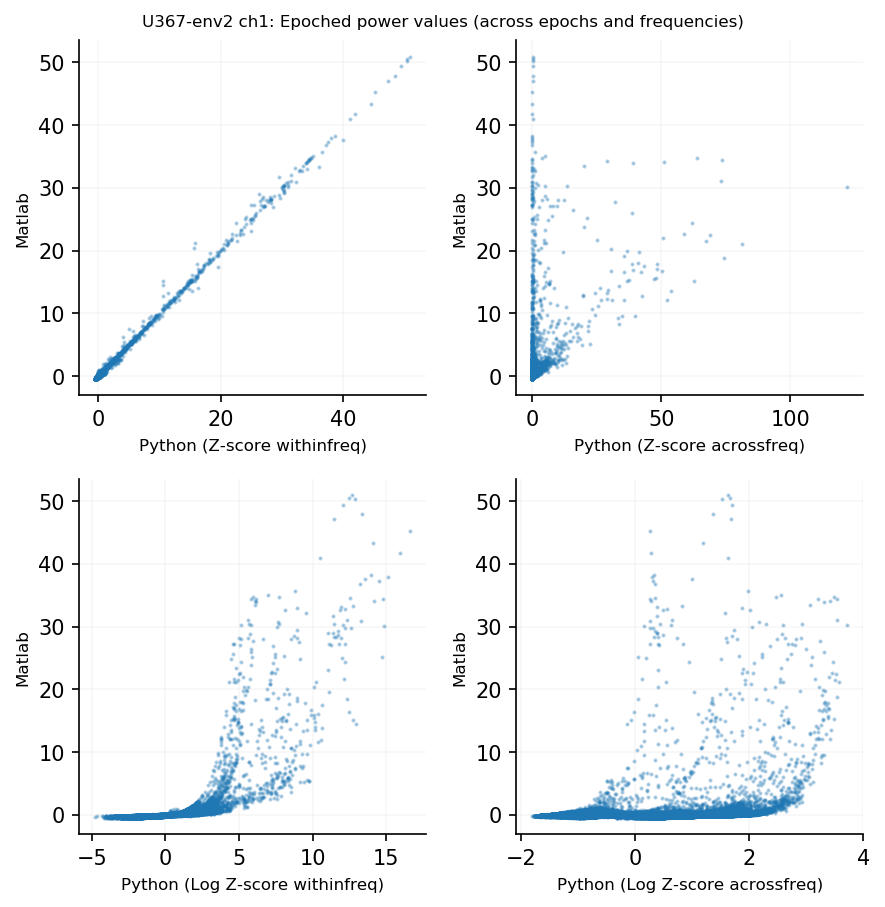

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=150)
ax = np.ravel(ax)

ax[0].scatter(epoch_power_zw.T.data.flatten(), mat['pow'][:, 3:-3].flatten(), s=1, alpha=0.3)
ax[0].set_xlabel('Python (Z-score withinfreq)', fontsize=8)
ax[0].set_ylabel('Matlab', fontsize=8)

ax[1].scatter(epoch_power_za.T.data.flatten(), mat['pow'][:, 3:-3].flatten(), s=1, alpha=0.3)
ax[1].set_xlabel('Python (Z-score acrossfreq)', fontsize=8)
ax[1].set_ylabel('Matlab', fontsize=8)

ax[2].scatter(epoch_power_lzw.T.data.flatten(), mat['pow'][:, 3:-3].flatten(), s=1, alpha=0.3)
ax[2].set_xlabel('Python (Log Z-score withinfreq)', fontsize=8)
ax[2].set_ylabel('Matlab', fontsize=8)

ax[3].scatter(epoch_power_lza.T.data.flatten(), mat['pow'][:, 3:-3].flatten(), s=1, alpha=0.3)
ax[3].set_xlabel('Python (Log Z-score acrossfreq)', fontsize=8)
ax[3].set_ylabel('Matlab', fontsize=8)

fig.tight_layout()
fig.suptitle('U367-env2 ch1: Epoched power values (across epochs and frequencies)', fontsize=8, y=1)

In [ ]:
n_epochs = len(epoch_power_zw.epoch)
epochs = [int(i) for i in np.random.rand(9) * n_epochs]

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))
ax = np.ravel(ax)
for i, epoch in enumerate(epochs):
    frZ = (epoch_fr.sel(cluster=0, epoch=epoch).data - epoch_fr.sel(cluster=0).mean('epoch')).data / epoch_fr.sel(cluster=0).std('epoch').data
    ax[i].plot(np.log10(freqs), np.ones(len(freqs))*frZ, linewidth=0.6, linestyle='--', color='C2', label='Normalized Firing Rate')
    ax[i].plot(np.log10(freqs), np.ones(len(freqs))*np.mean(mat['pow'][:, 3+epoch]), color='C0', linewidth=0.3, linestyle='--')
    ax[i].plot(np.log10(freqs), np.ones(len(freqs))*np.mean(epoch_power.sel(channel='1', epoch=epoch)).data, color='C1', linewidth=0.3, linestyle='--')
    ax[i].plot(np.log10(freqs), mat['pow'][:, 3+epoch], color='C0', label='Matlab')
    ax[i].plot(np.log10(freqs), epoch_power.sel(channel='1', epoch=epoch), color='C1', label='Python')
    
    ax[i].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[i].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[i].set_yticks([-2, -1, 0, 1, 2])
    ax[i].set_ylim([-3, 3])
    for item in ax[i].get_xticklabels() + ax[i].get_yticklabels():
        item.set_fontsize(8)
    for item in (ax[i].xaxis.label, ax[i].yaxis.label):
        item.set_fontsize(10)
    if i == 2:
        ax[i].legend(loc=1, prop={'size': 5}, edgecolor='w')
    if i == 6:
        ax[i].set_xlabel('Frequency (Hz)')
        ax[i].set_ylabel('Normalized Power')
    ax[i].set_title('Epoch {}'.format(epoch))
    
fig.suptitle('{}-ch1: Normalized power for 9 random epochs'.format(subj_sess), 
             y=0.93, fontsize=10)
f = os.path.join(figure_dir, 'matlab_vs_python_fr_vs_power_some_random_epochs_{}_ch{}.png'.format(subj_sess, chan))
fig.savefig(f)

Text(0.5,1.03,'U367-env2-ch1: Firing rate vs. Power')

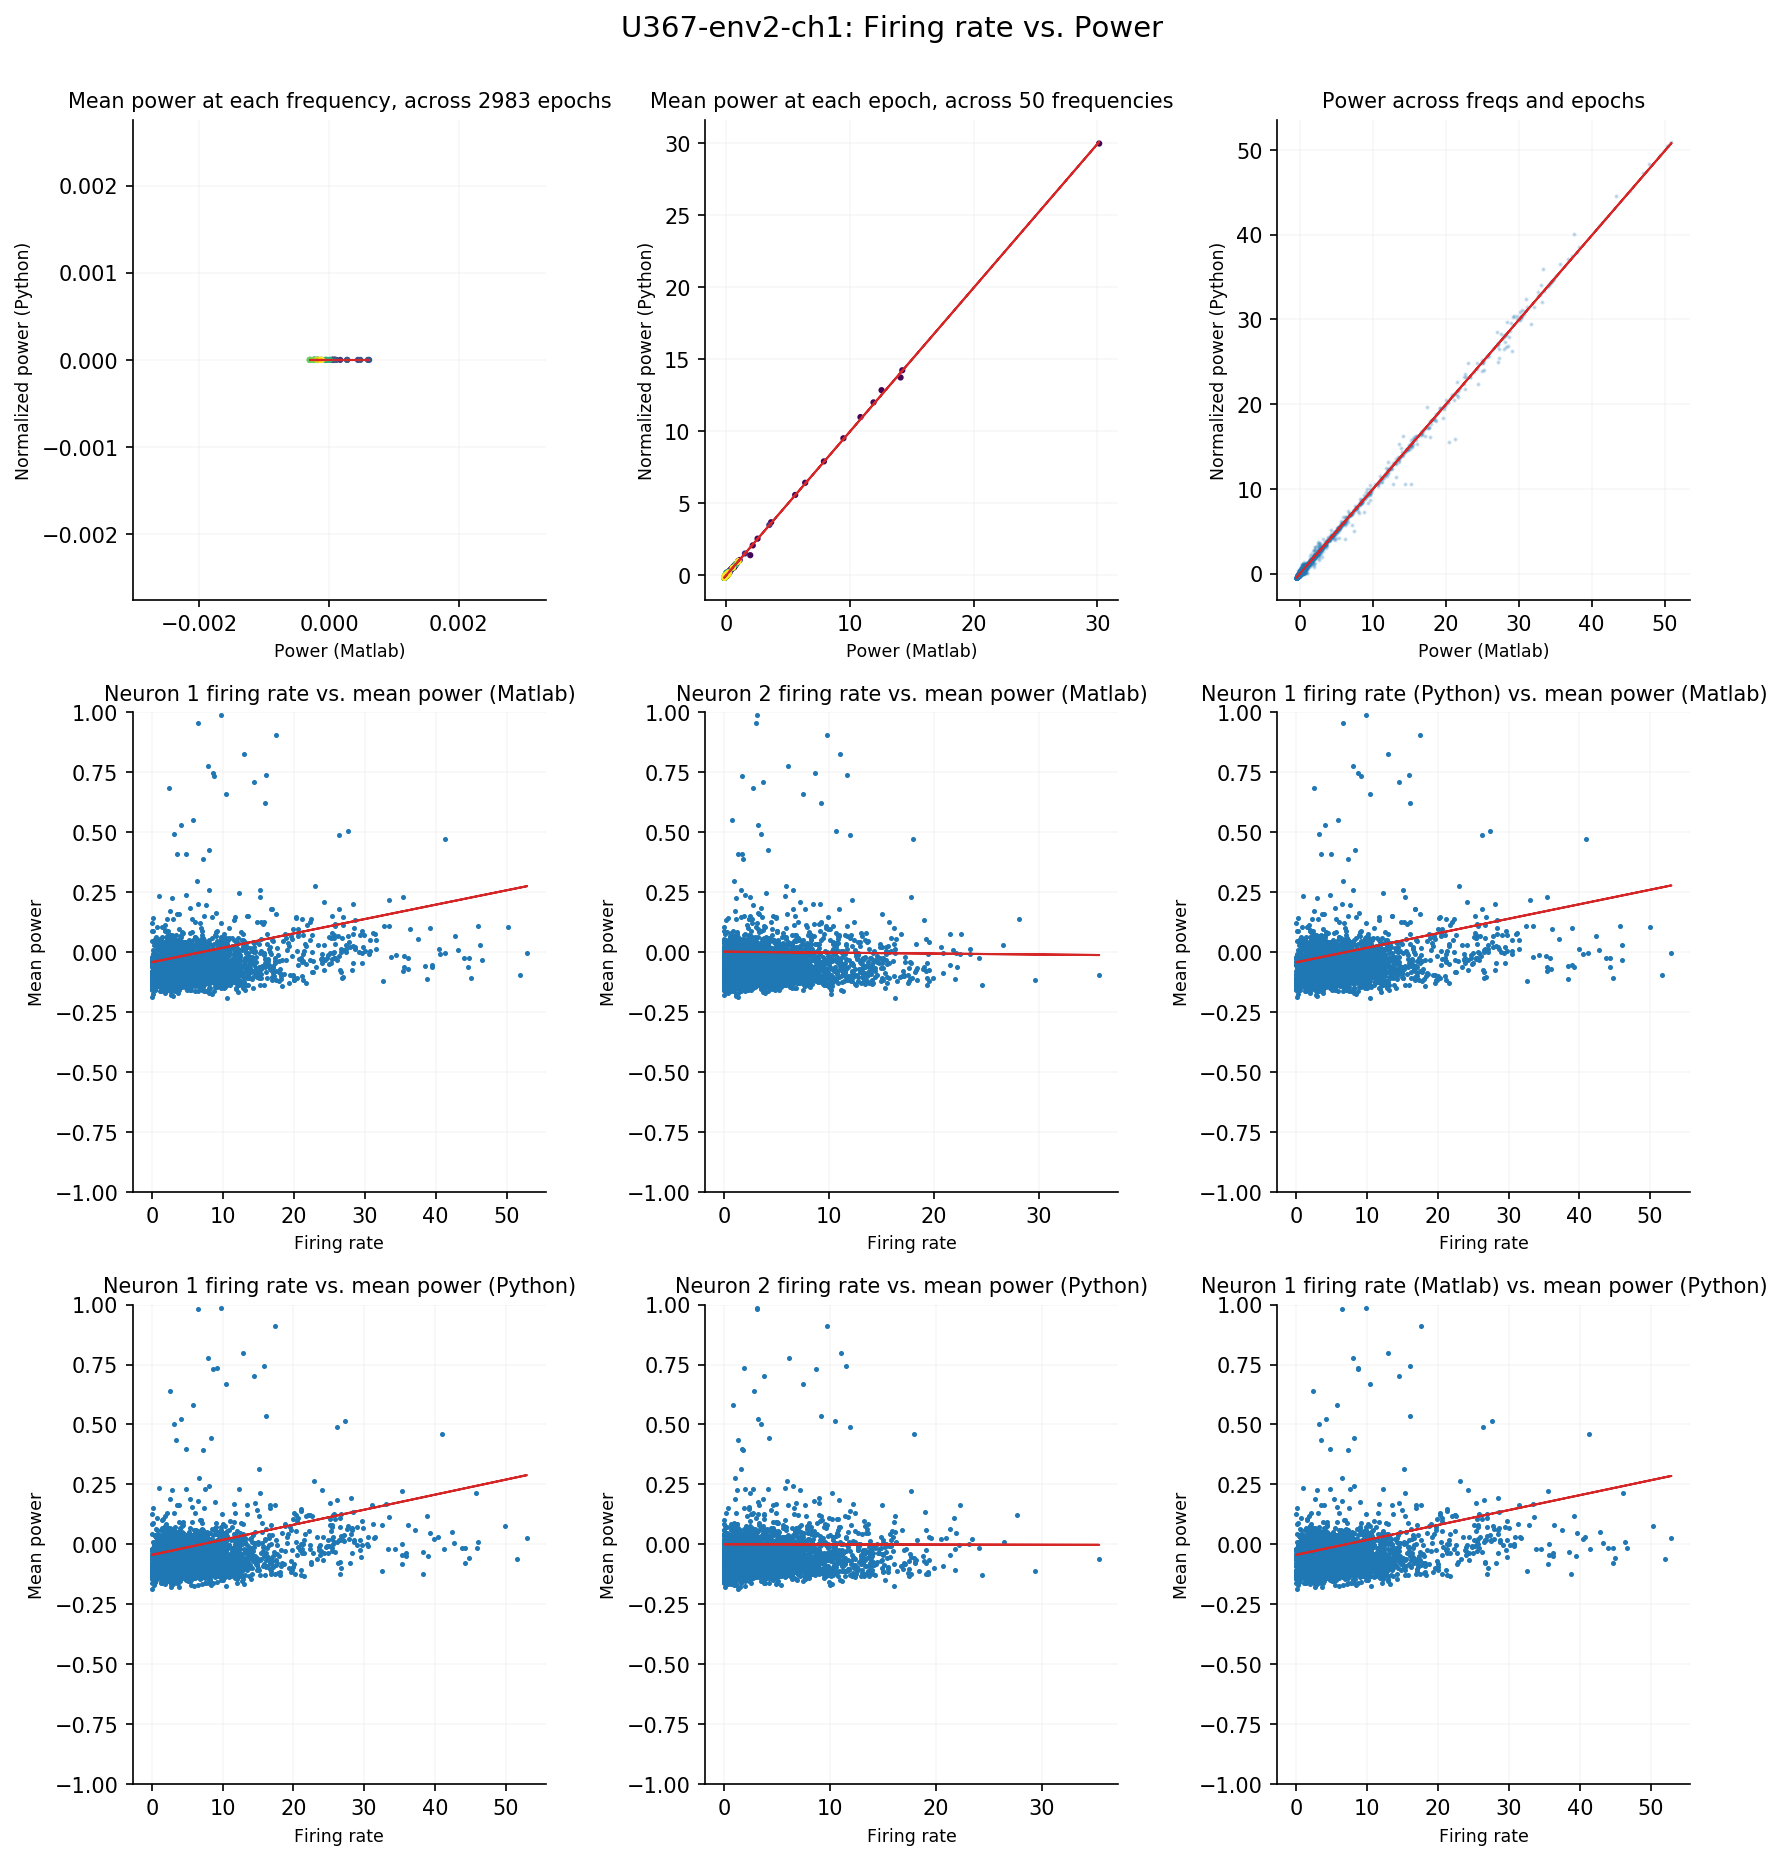

In [362]:
# withinfreq (power_width5_epoch_Zwithinfreq)

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = np.ravel(ax)

mat_power = mat['pow'][:, 3:-3]

ax[0].scatter(np.mean(mat_power, axis=1), epoch_power.mean('epoch'), 
              s=4, color=plt.cm.viridis(np.linspace(0, 1, mat_power.shape[0])))
xi = np.mean(mat_power, axis=1)
y = epoch_power.mean('epoch')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[0].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[0].set_xlabel('Power (Matlab)')
ax[0].set_ylabel('Normalized power (Python)')
ax[0].set_title('Mean power at each frequency, across 2983 epochs')

ax[1].scatter(np.mean(mat_power, axis=0), epoch_power.mean('freq'), 
              s=4, color=plt.cm.viridis(np.linspace(0, 1, mat_power.shape[1])))
xi = np.mean(mat_power, axis=0)
y = epoch_power.mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[1].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[1].set_xlabel('Power (Matlab)')
ax[1].set_ylabel('Normalized power (Python)')
ax[1].set_title('Mean power at each epoch, across 50 frequencies')

ax[2].scatter(mat_power.flatten(), epoch_power.T.data.flatten(), alpha=0.2, s=1)
xi = mat_power.flatten()
y = epoch_power.T.data.flatten()
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[2].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[2].set_xlabel('Power (Matlab)')
ax[2].set_ylabel('Normalized power (Python)')
ax[2].set_title('Power across freqs and epochs')

###################

ax[3].scatter(mat['smSpikeRate'][0, 3:-3], np.mean(mat_power, axis=0), s=2)
xi = mat['smSpikeRate'][0, 3:-3]
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[3].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[3].set_xlabel('Firing rate')
ax[3].set_ylim((-1, 1))
ax[3].set_ylabel('Mean power')
ax[3].set_title('Neuron 1 firing rate vs. mean power (Matlab)')

ax[4].scatter(mat['smSpikeRate'][1, 3:-3], np.mean(mat_power, axis=0), s=2)
xi = mat['smSpikeRate'][1, 3:-3]
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[4].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[4].set_xlabel('Firing rate')
ax[4].set_ylim((-1, 1))
ax[4].set_ylabel('Mean power')
ax[4].set_title('Neuron 2 firing rate vs. mean power (Matlab)')

ax[5].scatter(epoch_fr.sel(cluster=0), np.mean(mat_power, axis=0), s=2)
xi = epoch_fr.sel(cluster=0)
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[5].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[5].set_xlabel('Firing rate')
ax[5].set_ylim((-1, 1))
ax[5].set_ylabel('Mean power')
ax[5].set_title('Neuron 1 firing rate (Python) vs. mean power (Matlab)')

###################

ax[6].scatter(epoch_fr.sel(cluster=0), epoch_power.mean('freq'), s=2)
xi = epoch_fr.sel(cluster=0)
y = epoch_power.mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[6].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[6].set_xlabel('Firing rate')
ax[6].set_ylim((-1, 1))
ax[6].set_ylabel('Mean power')
ax[6].set_title('Neuron 1 firing rate vs. mean power (Python)')

ax[7].scatter(epoch_fr.sel(cluster=1), epoch_power.mean('freq'), s=2)
xi = epoch_fr.sel(cluster=1)
y = epoch_power.mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[7].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[7].set_xlabel('Firing rate')
ax[7].set_ylim((-1, 1))
ax[7].set_ylabel('Mean power')
ax[7].set_title('Neuron 2 firing rate vs. mean power (Python)')

ax[8].scatter(mat['smSpikeRate'][0, 3:-3], epoch_power.mean('freq'), s=2)
xi = mat['smSpikeRate'][0, 3:-3]
y = epoch_power.mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[8].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[8].set_xlabel('Firing rate')
ax[8].set_ylim((-1, 1))
ax[8].set_ylabel('Mean power')
ax[8].set_title('Neuron 1 firing rate (Matlab) vs. mean power (Python)')

fig.tight_layout(pad=1.12)
fig.suptitle('U367-env2-ch1: Firing rate vs. Power', y=1.03, size=14)
#f = os.path.join(figure_dir, 'matlab_vs_python_epoch_fr_vs_power_{}_ch{}.png'.format(subj_sess, chan))
#fig.savefig(f)

Text(0.5,1.03,'U367-env2-ch1: Firing rate vs. Power')

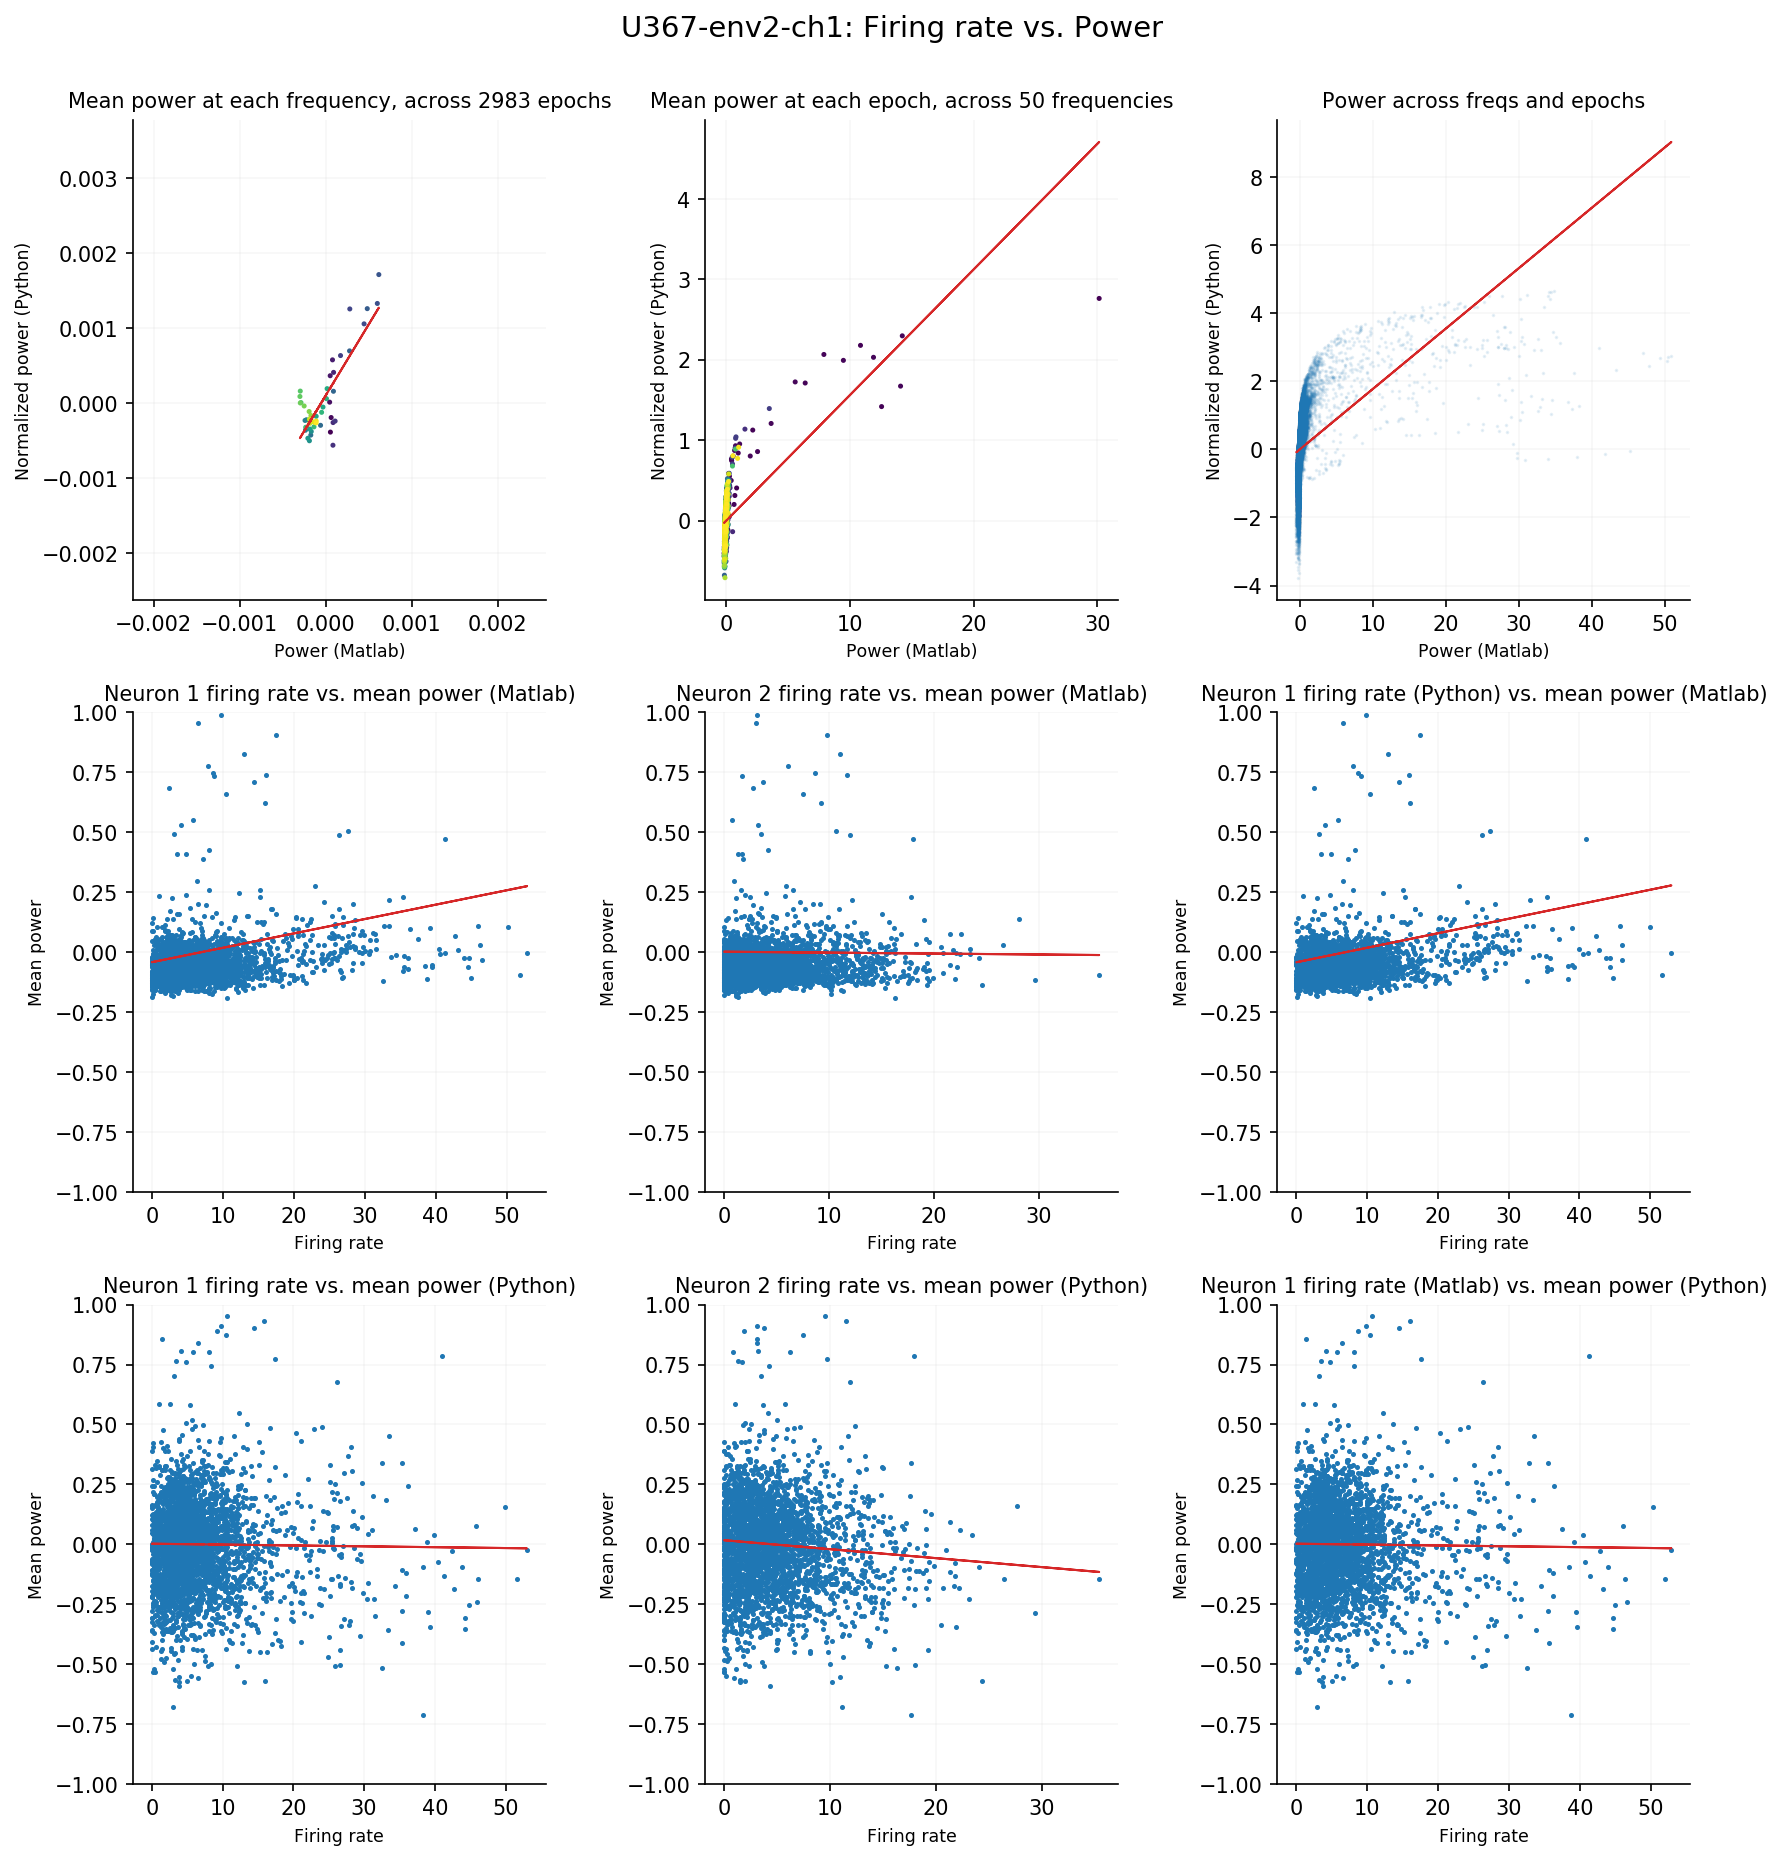

In [150]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = np.ravel(ax)

mat_power = mat['pow'][:, 3:-3]

ax[0].scatter(np.mean(mat_power, axis=1), epoch_power.sel(channel='1').mean('epoch'), 
              s=2, color=plt.cm.viridis(np.linspace(0, 1, mat_power.shape[0])))
xi = np.mean(mat_power, axis=1)
y = epoch_power.sel(channel='1').mean('epoch')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[0].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[0].set_xlabel('Power (Matlab)')
ax[0].set_ylabel('Normalized power (Python)')
ax[0].set_title('Mean power at each frequency, across 2983 epochs')

ax[1].scatter(np.mean(mat_power, axis=0), epoch_power.sel(channel='1').mean('freq'), 
              s=2, color=plt.cm.viridis(np.linspace(0, 1, mat_power.shape[1])))
xi = np.mean(mat_power, axis=0)
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[1].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[1].set_xlabel('Power (Matlab)')
ax[1].set_ylabel('Normalized power (Python)')
ax[1].set_title('Mean power at each epoch, across 50 frequencies')

ax[2].scatter(mat_power.flatten(), epoch_power.sel(channel='1').T.data.flatten(), alpha=0.1, s=0.5)
xi = mat_power.flatten()
y = epoch_power.sel(channel='1').T.data.flatten()
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[2].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[2].set_xlabel('Power (Matlab)')
ax[2].set_ylabel('Normalized power (Python)')
ax[2].set_title('Power across freqs and epochs')

###################

ax[3].scatter(mat['smSpikeRate'][0, 3:-3], np.mean(mat_power, axis=0), s=2)
xi = mat['smSpikeRate'][0, 3:-3]
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[3].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[3].set_xlabel('Firing rate')
ax[3].set_ylim((-1, 1))
ax[3].set_ylabel('Mean power')
ax[3].set_title('Neuron 1 firing rate vs. mean power (Matlab)')

ax[4].scatter(mat['smSpikeRate'][1, 3:-3], np.mean(mat_power, axis=0), s=2)
xi = mat['smSpikeRate'][1, 3:-3]
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[4].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[4].set_xlabel('Firing rate')
ax[4].set_ylim((-1, 1))
ax[4].set_ylabel('Mean power')
ax[4].set_title('Neuron 2 firing rate vs. mean power (Matlab)')

ax[5].scatter(epoch_fr.sel(cluster=0), np.mean(mat_power, axis=0), s=2)
xi = epoch_fr.sel(cluster=0)
y = np.mean(mat_power, axis=0)
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[5].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[5].set_xlabel('Firing rate')
ax[5].set_ylim((-1, 1))
ax[5].set_ylabel('Mean power')
ax[5].set_title('Neuron 1 firing rate (Python) vs. mean power (Matlab)')

###################

ax[6].scatter(epoch_fr.sel(cluster=0), epoch_power.sel(channel='1').mean('freq'), s=2)
xi = epoch_fr.sel(cluster=0)
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[6].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[6].set_xlabel('Firing rate')
ax[6].set_ylim((-1, 1))
ax[6].set_ylabel('Mean power')
ax[6].set_title('Neuron 1 firing rate vs. mean power (Python)')

ax[7].scatter(epoch_fr.sel(cluster=1), epoch_power.sel(channel='1').mean('freq'), s=2)
xi = epoch_fr.sel(cluster=1)
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[7].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[7].set_xlabel('Firing rate')
ax[7].set_ylim((-1, 1))
ax[7].set_ylabel('Mean power')
ax[7].set_title('Neuron 2 firing rate vs. mean power (Python)')

ax[8].scatter(mat['smSpikeRate'][0, 3:-3], epoch_power.sel(channel='1').mean('freq'), s=2)
xi = mat['smSpikeRate'][0, 3:-3]
y = epoch_power.sel(channel='1').mean('freq')
slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
ax[8].plot(xi, slope * xi + intercept, color='C1', linewidth=1)
ax[8].set_xlabel('Firing rate')
ax[8].set_ylim((-1, 1))
ax[8].set_ylabel('Mean power')
ax[8].set_title('Neuron 1 firing rate (Matlab) vs. mean power (Python)')

fig.tight_layout(pad=1.12)
fig.suptitle('U367-env2-ch1: Firing rate vs. Power', y=1.03, size=14)
#f = os.path.join(figure_dir, 'matlab_vs_python_epoch_fr_vs_power_{}_ch{}.png'.format(subj_sess, chan))
#fig.savefig(f)

## Old

## Notes

- effect of doing frequencies from 2 to 100, 150, or 200 Hz?
- effect of time window size (200 ms, 500 ms, 1000 ms)?
- why does log transform need to be done after epoching and not before?